In [14]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np

from sklearn.model_selection import train_test_split

# Set path
data_path = "/content/drive/MyDrive/book-rating-cf/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd

# File paths
users_file = os.path.join(data_path, "Users.csv")
books_file = os.path.join(data_path, "Books.csv")
ratings_file = os.path.join(data_path, "Ratings.csv")

# Load datasets
users = pd.read_csv(users_file, encoding='latin-1')
books = pd.read_csv(books_file, encoding='latin-1')
ratings = pd.read_csv(ratings_file, encoding='latin-1')

# Preview first few rows
print("Users:")
display(users.head())

print("\nBooks:")
display(books.head())

print("\nRatings:")
display(ratings.head())


<ipython-input-15-56821cdbc6f3>:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv(books_file, encoding='latin-1')


Users:


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN



Books:


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...



Ratings:


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Step 2: Clean the data

In [16]:
print("Missing values in Users:")
print(users.isnull().sum())

print("\nMissing values in Books:")
print(books.isnull().sum())

print("\nMissing values in Ratings:")
print(ratings.isnull().sum())


Missing values in Users:
User-ID          0
Location         0
Age         110762
dtype: int64

Missing values in Books:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Missing values in Ratings:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [17]:
# ✅ Required minimal cleaning
ratings = ratings[ratings['Book-Rating'] > 0]  # Remove unrated
ratings = ratings.drop_duplicates()            # Remove duplicate rows


In [18]:
# 6. Filter: keep only active users and popular books
MIN_USER_RATINGS = 10
MIN_BOOK_RATINGS = 10

user_counts = ratings['User-ID'].value_counts()
active_users = user_counts[user_counts >= MIN_USER_RATINGS].index

book_counts = ratings['ISBN'].value_counts()
popular_books = book_counts[book_counts >= MIN_BOOK_RATINGS].index

filtered_ratings = ratings[
    ratings['User-ID'].isin(active_users) &
    ratings['ISBN'].isin(popular_books)
]

print("✅ Ratings after filtering:")
print(f"Total Ratings: {len(filtered_ratings)}")
print(f"Unique Users: {filtered_ratings['User-ID'].nunique()}")
print(f"Unique Books: {filtered_ratings['ISBN'].nunique()}")

# 7. Train-test split (75/25) by (user, book) rating pairs
train_df, test_df = train_test_split(filtered_ratings, test_size=0.25, random_state=42)

# Keep only test users that exist in training
test_df = test_df[test_df['User-ID'].isin(train_df['User-ID'])]

print("\n✅ Final split:")
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

# 8. Create user-item matrix for training
train_matrix = train_df.pivot(index='User-ID', columns='ISBN', values='Book-Rating')

✅ Ratings after filtering:
Total Ratings: 90556
Unique Users: 6837
Unique Books: 5640

✅ Final split:
Train size: 67917
Test size: 22390


Step 3: train-test split

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# 1. Fill missing values with 0 (book not rated by a user)
train_matrix_filled = train_matrix.fillna(0)

# 2. Transpose to get books as rows, users as columns
item_user_matrix = train_matrix_filled.T

# 3. Compute cosine similarity between items
item_similarity = cosine_similarity(item_user_matrix)

# 4. Wrap in a DataFrame for easy look-up
item_similarity_df = pd.DataFrame(item_similarity,
                                  index=item_user_matrix.index,
                                  columns=item_user_matrix.index)

# Preview similarity between some books
item_similarity_df.iloc[:5, :5]


ISBN,0002558122,000648302X,000649840X,0006513204,0006513220
ISBN,,,,,
0002558122,1.0,0.000000,0.000000,0.000000,0.0
000648302X,0.0,1.000000,0.159098,0.303552,0.0
000649840X,0.0,0.159098,1.000000,0.109417,0.0
0006513204,0.0,0.303552,0.109417,1.000000,0.0
0006513220,0.0,0.000000,0.000000,0.000000,1.0


In [20]:
def predict_item_item(user_id, target_isbn, k=10):
    """
    Predict rating that user_id would give to target_isbn based on item-item CF.
    """
    # Check if book and user exist in training matrix
    if target_isbn not in item_similarity_df.columns:
        return np.nan
    if user_id not in train_matrix.index:
        return np.nan

    # Books that this user has rated
    user_ratings = train_matrix.loc[user_id].dropna()

    # Similarity scores between target book and books the user has rated
    similarities = item_similarity_df[target_isbn].drop(index=target_isbn, errors='ignore')  # drop self-similarity
    similarities = similarities[user_ratings.index.intersection(similarities.index)]

    # If there are no common books rated by user
    if similarities.empty:
        return np.nan

    # Top-k similar books
    top_k_similarities = similarities.sort_values(ascending=False).head(k)
    top_k_ratings = user_ratings[top_k_similarities.index]

    # Compute weighted average
    weighted_sum = np.dot(top_k_similarities.values, top_k_ratings.values)
    sim_sum = np.sum(np.abs(top_k_similarities.values))

    if sim_sum == 0:
        return np.nan

    return weighted_sum / sim_sum


In [21]:
predictions = []
actuals = []

# Use smaller sample if needed for testing
for idx, row in test_df.iterrows():
    user = row['User-ID']
    isbn = row['ISBN']
    true_rating = row['Book-Rating']

    pred = predict_item_item(user, isbn, k=10)

    if not np.isnan(pred):
        predictions.append(pred)
        actuals.append(true_rating)


In [22]:
from sklearn.metrics import mean_absolute_error

mad = mean_absolute_error(actuals, predictions)
print(f"📉 Mean Absolute Difference (MAD) for k=10: {mad:.4f}")


📉 Mean Absolute Difference (MAD) for k=10: 1.2343


In [23]:
k_values = [5, 10, 15, 20, 50, 100]
mad_scores = []

for k in k_values:
    print(f"\n🔍 Evaluating for k = {k}...")
    preds = []
    actuals = []

    for idx, row in test_df.iterrows():
        user = row['User-ID']
        isbn = row['ISBN']
        true_rating = row['Book-Rating']

        pred = predict_item_item(user, isbn, k=k)

        if not np.isnan(pred):
            preds.append(pred)
            actuals.append(true_rating)

    mad = mean_absolute_error(actuals, preds)
    mad_scores.append(mad)
    print(f"MAD @ k={k}: {mad:.4f}")



🔍 Evaluating for k = 5...
MAD @ k=5: 1.2460

🔍 Evaluating for k = 10...
MAD @ k=10: 1.2343

🔍 Evaluating for k = 15...
MAD @ k=15: 1.2325

🔍 Evaluating for k = 20...
MAD @ k=20: 1.2318

🔍 Evaluating for k = 50...
MAD @ k=50: 1.2328

🔍 Evaluating for k = 100...
MAD @ k=100: 1.2327


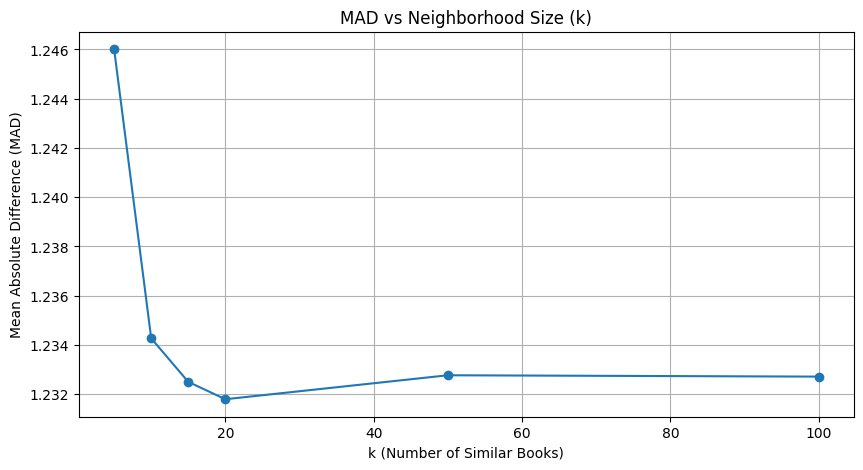

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(k_values, mad_scores, marker='o')
plt.title('MAD vs Neighborhood Size (k)')
plt.xlabel('k (Number of Similar Books)')
plt.ylabel('Mean Absolute Difference (MAD)')
plt.grid(True)
plt.show()


In [25]:
split_ratios = [0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
mad_scores_split = []
k_for_all = 10  # You can fix k to a value like 10

for split in split_ratios:
    print(f"\n🔁 Evaluating for Train Ratio = {int(split * 100)}%...")

    # Split the data
    train_df, test_df = train_test_split(filtered_ratings, train_size=split, random_state=42)
    test_df = test_df[test_df['User-ID'].isin(train_df['User-ID'])]  # Ensure overlap

    # Create training matrix
    train_matrix = train_df.pivot(index='User-ID', columns='ISBN', values='Book-Rating').copy()
    train_matrix_filled = train_matrix.fillna(0)
    item_user_matrix = train_matrix_filled.T

    # Compute item-item similarity
    item_similarity = cosine_similarity(item_user_matrix)
    item_similarity_df = pd.DataFrame(item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index)

    # Predict and evaluate
    preds = []
    actuals = []

    for idx, row in test_df.iterrows():
        user = row['User-ID']
        isbn = row['ISBN']
        true_rating = row['Book-Rating']

        pred = predict_item_item(user, isbn, k=k_for_all)
        if not np.isnan(pred):
            preds.append(pred)
            actuals.append(true_rating)

    mad = mean_absolute_error(actuals, preds)
    mad_scores_split.append(mad)
    print(f"MAD for Train {int(split * 100)}%: {mad:.4f}")



🔁 Evaluating for Train Ratio = 60%...
MAD for Train 60%: 1.2518

🔁 Evaluating for Train Ratio = 65%...
MAD for Train 65%: 1.2464

🔁 Evaluating for Train Ratio = 70%...
MAD for Train 70%: 1.2424

🔁 Evaluating for Train Ratio = 75%...
MAD for Train 75%: 1.2343

🔁 Evaluating for Train Ratio = 80%...
MAD for Train 80%: 1.2278

🔁 Evaluating for Train Ratio = 85%...
MAD for Train 85%: 1.2165

🔁 Evaluating for Train Ratio = 90%...
MAD for Train 90%: 1.2039


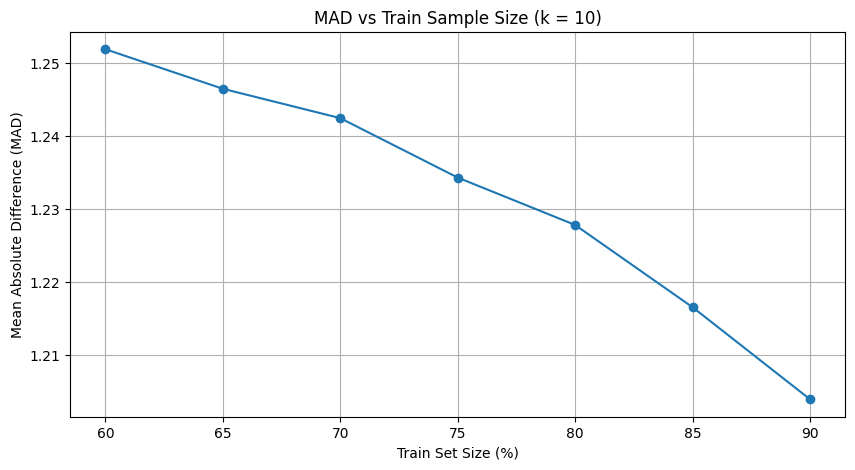

In [26]:
plt.figure(figsize=(10, 5))
plt.plot([int(s * 100) for s in split_ratios], mad_scores_split, marker='o')
plt.title(f'MAD vs Train Sample Size (k = {k_for_all})')
plt.xlabel('Train Set Size (%)')
plt.ylabel('Mean Absolute Difference (MAD)')
plt.grid(True)
plt.show()
